In [1]:
library(DBI)
library(RSQLite)
library(dplyr)
library(ggplot2)
library(odbc)
library(Hmisc)
library(corrplot)
library(MESS)
library(ggExtra)
library(naniar)
library(mvoutlier)
library(MissMech)
library(mice)
library(MatchIt)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'odbc' was built under R version 3.6.2"
Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: 'Hmisc'


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    format.pval, units


corrplot 0.84 loaded

Warning message:
"package 'MESS' was built under R version 3.6.2"
Warning message:
"package 'ggExtra' was built under R version 3.6.2"
Warning message:
"package 'naniar' was built under R version 3.6.2"
Loading required package: sgeostat

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

sROC 0.1-2 loaded

Registered S3 methods overwritten by 'lme4':
  method                          

In [2]:
load("C:/Users/meir/Documents/DataScience/data/BoxOffice_ff_v.RData")

# 1. Descriptive statistics of the data 

In [30]:
summary(movies_ff_v)

    movie_id        budget          original_language    popularity     
 Min.   :   1   Min.   :        0   Length:7375        Min.   :  0.000  
 1st Qu.:1848   1st Qu.:        0   Class :character   1st Qu.:  3.970  
 Median :3696   Median :  8000000   Mode  :character   Median :  7.456  
 Mean   :3698   Mean   : 22666657                      Mean   :  8.540  
 3rd Qu.:5550   3rd Qu.: 29000000                      3rd Qu.: 10.932  
 Max.   :7398   Max.   :380000000                      Max.   :547.488  
                                                                        
  release_date           runtime      runtime_cat           revenue         
 Min.   :1918-08-01   Min.   :  0.0   Length:7375        Min.   :1.000e+00  
 1st Qu.:1992-11-13   1st Qu.: 94.0   Class :character   1st Qu.:2.405e+06  
 Median :2004-07-29   Median :104.0   Mode  :character   Median :1.693e+07  
 Mean   :2000-03-15   Mean   :107.7                      Mean   :6.688e+07  
 3rd Qu.:2011-06-27   3rd Qu.:1

In [ ]:
summary(movies_ff_v)

# 2. Graphical statistics of the data

In [32]:
############################################################################
#####   Package mechkar                                                 ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-05-01                                       ####
############################################################################
exploreData <- function(y=NULL, data=data, factorSize=10, dir="report", ...) {

  get_computer_type <- function(){
    # check if current R client is running on PC or on the server
    if (Sys.info()[1] == "Windows") {
      computer.type = "pc"
    } else if (Sys.info()[1] == "Linux") {
      computer.type = "server"
    }
    return(computer.type)
  }

  whatVarType <- function(var) {
    suppressWarnings(if (var=="integer" | var=="numeric") {
      return(1)
    } else if (var=="factor" | var=="character") {
      return(2)
    } else if (var=="Date" | "POSIXct" %in% var[[1]]) {
      return(3)
    } else {
      return(0)
    })
  }

  drawHistogram <- function(imgname=imgname, x=x) {
    d=stats::density(x, kernel = "gaussian",na.rm=TRUE)
    breakstar=(max(x,na.rm=TRUE) -min(x,na.rm=TRUE))/d$bw
    h=graphics::hist(x, breaks=breakstar)
    graphics::plot(h,main="",xlab=imgname)
    yfit<-seq(min(x,na.rm=TRUE),max(x,na.rm=TRUE),length=40)
    ffit<-stats::dnorm(yfit,mean=mean(x,na.rm=T),sd=stats::sd(x,na.rm=T))
    ffit <- ffit*diff(h$mids[1:2])*length(x)
    lines(yfit, ffit, col="blue", lwd=2)
  }

  drawFakeGraph <- function(imgname=imgname) {
    graphics::plot.window(xlim = c(0,0),ylim = c(0,0))
  }

  drawBars <- function(imgname=imgname, x=x) {
    graphics::plot(x)
  }

  drawGraphOne <- function(imgname=imgname, numVar=x, vartype=1) {
    if(vartype==1) {
      drawHistogram(imgname,numVar)
    } else if(vartype==2) {
      drawBars(imgname,numVar)
    } else {
      drawFakeGraph(imgname)
    }
  }

  getContinuousStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    me <- formatC(stats::median(x, na.rm=TRUE))
    q1 <- formatC(stats::quantile(x,1/4, na.rm=TRUE))
    q3 <- formatC(stats::quantile(x,3/4, na.rm=TRUE))
    mn <- formatC(min(x, na.rm=TRUE))
    mx <- formatC(max(x, na.rm=TRUE))
    html <- paste("<div class='Cell' style='align: top;'> <u>Data type</u>: Continuous <p> <u>Data length</u>: ",n ,"/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%)<p> <u>Mean</u>: ", formatC(ma), "\t <u>StdDev</u>: ", formatC(s), "<br><u>Median</u>: ",me,
                  "\t <u>IQR</u>: ", q1, "-", q3, "<br><u>Min</u>: ", mn, "\t <u>Max</u>: ", mx, "</div>")
    return(html)
  }

  getCategortyStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    l <- levels(x)
    s <- summary(x)
    htm <- "<ul>"
    if (length(l) < 5) {
      for (lv in l) {
        htm <- paste(htm, "<li><u>", lv, "</u>: ", s[[lv]], "</li>")
      }
      htm <- paste(htm,"</ul>")
    }
    html <- paste("<div class='Cell'> <u>Data type</u>: Categorical Data <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Number of levels</u>: ", length(l), "<br>", htm, "</div>")
    return(html)
  }

  getDatesStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    s <- summary(x)
    html <- paste("<div class='Cell'> <u>Data type</u>: Date <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Min date</u>: ", min(x, na.rm=T), "<br><u>Max date</u>:",max(x, na.rm=T) , "</div>")
    return(html)
  }

  getStats <- function(numVar=x, vartype=1) {
    if(vartype==1) {
      html <- getContinuousStats(numVar)
    } else if(vartype==2) {
      html <- getCategortyStats(numVar)
    } else if (vartype==3) {
      html <- getDatesStats(numVar)
    } else {
      html <- "<div class='Cell'></div>"
    }
    return(html)
  }

  getOutliers <- function(x) {
    bp <- graphics::boxplot(x,plot=FALSE)
    return(bp$out)
  }

  getOutlierGraph <- function(x) {
    #  mod <- tryCatch({
    outl <- getOutliers(x)
    df <- data.frame(x=x, cl=1)
    if(length(outl)>0) {
      df$cl[which(df$x %in% outl)] <- 2
    }
    pl <- stats::scatter.smooth(df$x,col=df$cl)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    graphics::abline(h=ma-(2*s), col="red", lty=2)
    graphics::abline(h=ma+(2*s), col="red", lty=2)
    #  }, error = function(e) {
    #    pl <- drawFakeGraph("none")
    #  })
    return(pl)
  }

  getScatterGraph <- function(df=data,x,y,dtype=1) {
    #  mod <- tryCatch({
    if(dtype==1) {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_smooth(aes(x=data[[x]], y=data[[y]]), method="loess") + xlab(x) + ylab(y)
    } else {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_boxplot(aes(y=data[[x]], color=data[[y]])) + xlab(x) + ylab(y) + labs(color=y)
    }
    return(pl)
  }

  getOutliersHtml <- function(imgname=imgname, x=x, srcdir=srcdir) {
    bp <- getOutliers(x)
    if (length(unique(bp)) > 10) {
      xtrm <- paste("There are ", length(unique(bp)), " outlier values")
    } else if (length(unique(bp)) == 0) {
      xtrm <- "No outlier values found"
    } else {
      xtrm <- paste(formatC(bp), collapse=', ' )
    }
    imgsrc = paste(paste0(srcdir,"/fig/"),imgname, "_2.png",sep="")
    html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='250'><br> <u>Outlier values</u>: <br> ", xtrm, "</div>")
    return(html)
  }
  ################## Prepare for the report ###################
  #report <- paste(mydir,"/report",sep="")
  report <- dir
  if (!file.exists(report)) {
    dir.create(report)
  }
  fig <- paste(report,"/fig",sep="")
  if (!file.exists(fig)) {
    dir.create(fig)
  }
  if (get_computer_type()=="pc") {
    srcdir <- paste0(getwd(),"/",report)
  } else {
    srcdir <- paste0("file_show?path=",getwd(),"/",report)
  }
  # determine which columns are integer
  int_col <- which(sapply(data, is.integer))
  int_col <- c(int_col,(which(sapply(data, is.numeric))))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in int_col) {
    if (length(unique(data[,li])) < factorSize) {
      mi <- c(mi,li)
      if (is.factor(data[,li]) == FALSE) {
        data[,li] <- factor(data[,li])
      }
    }
  }

  str_col <- which(sapply(data, is.character))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in str_col) {
    mi <- c(mi,li)
    data[,li] <- factor(data[,li])
  }

  # create the html report page
  myhtml <- paste(report,"/report.html",sep="")
  cat("<!DOCTYPE html>
      <html>
      <head>
      <title>Data Visualization</title>
      <meta http-equiv='Content-Type' content='text/html; charset=UTF-8' />
      <link rel='stylesheet' href='http://code.jquery.com/mobile/1.4.5/jquery.mobile-1.4.5.min.css'>

      <script src='http://code.jquery.com/jquery-1.10.2.js'></script>
      <script>
      $(document).ready(function(){
      $('.onetoone').hide();
      });

      $(function() {
      $('.origimg').click(function(e) {
      $('#popup_img').attr('src',$(this).attr('src'));
      $('#myContainer').hide();
      var pos = $(document).scrollTop();
      $('#myContainer').css({'top':pos+20,'left':250, 'position':'absolute', 'border':'1px solid black', 'padding':'0px'});
      $('#myContainer').show();
      });
      $('#myContainer').click(function(e) {
      $('#myContainer').hide();
      });

      $('#myform2').submit(function(e) {
      e.preventDefault();
      });

      $('#onetoone').on('click',function() {
      console.log('onetone button - 1');
      $('#onetoone').hide();
      $('#aslist').show();
      // To show only individual rows:
      $('.Row').hide();
      $('.onetoone').show();
      // then we iterate
      var i = $('.Row').length;
      // Then we iterate
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('onetone button - 2');
      });

      $('#aslist').on('click',function() {
      console.log('aslist button - 1');
      $('#onetoone').show();
      $('#aslist').hide();
      $('.onetoone').hide();
      $('.Row').show();
      console.log('aslist button - 2');
      });

      $('#less').on('click',function(){
      console.log('less button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) - 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('less button - 2');
      });

      $('#more').on('click',function(){
      console.log('more button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) + 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('more button - 2');
      });

      $('#idx').on('change', function(){
      console.log('idx changed - 1');
      var i = $('.Row').length;
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('idx changed - 2');
      });
      });

      </script>

      <style type='text/css'>
      .Table
      {
      display: table;
      }
      .Title
      {
      display: table-caption;
      text-align: center;
      font-weight: bold;
      font-size: larger;
      }
      .Row
      {
      display: table-row;
      }
      .Cell
      {
      display: table-cell;
      border: solid;
      border-width: thin;
      padding-left: 5px;
      padding-right: 5px;
      vertical-align: top;
      font-family: 'arial';
      font-size: 14px;
      }
      </style>

      </head>

      <body>
      <div id='pageone' data-role='main' class='ui-content'>
      ", file = myhtml, sep='\n',append=FALSE)

  html <- paste("<p><p><h1> Data Visualization & Exploration </h1>
                <form>
                <input type='button' id='onetoone' value='Show as Cards'>
                <input type='button' id='aslist' class='onetoone' value='Show as List'>
                </form>
                <p>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # begin table
  alt1 <- ifelse(is.null(y)== TRUE, "", "<div class='Cell Title'> Dependent <br> Variable <br> Distribution </div>")
  html <- paste("<p><p>
                <div class='Table'>
                <div class='Row'>
                <div class='Cell Title'> Variable </div>
                <div class='Cell Title'> Distribution </div>
                <div class='Cell Title'> Descriptive <br> Statistics</div>
                <div class='Cell Title'> Outliers </div>"
                , alt1,
                "</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)

  #### determinate the type of each variable...
  data_types <- sapply(sapply(data, class), whatVarType)

  for(x in names(data)) {
    print(x)
    html <- paste("<div class='Row'><div class='Cell'><b>",x,"</b></div>")
    cat(html, file = myhtml, sep='\n', append=TRUE)
    #### initialize the first graph
    imgname = paste(fig,"/",x, "_1.png",sep="")
    imgsrc = paste(paste0(srcdir,"/fig/"),x, "_1.png",sep="")
    ### send the data with the type to generate the correct graph..
    grDevices::png(imgname)
    drawGraphOne(x, data[[x]], data_types[x])
    grDevices::dev.off()
    html <- paste0("<div class='Cell'><img class='origimg'  src='",imgsrc,"' height='150' width='150'><br></div>")
    cat(html, file = myhtml, sep='\n', append=TRUE)

    # second, show the statistics
    html <- getStats(data[[x]],data_types[x])
    cat(html, file = myhtml, sep='\n', append=TRUE)

    # third, determine the outliers
    imgname = paste(fig,"/",x, "_2.png",sep="")
    if(data_types[x]==1) {
      grDevices::png(imgname)
      getOutlierGraph(data[[x]])
      grDevices::dev.off()
      html <- getOutliersHtml(x,data[[x]],srcdir)
    } else {
      html <- "<div class='Cell'></div>"
    }
    cat(html, file = myhtml, sep='\n', append=TRUE)

    # fourth, if y is assigned, make a corresponding plot
    if(is.null(y)==FALSE) {
      imgname = paste(fig,"/",x, "_3.png",sep="")
      imgsrc = paste(paste0(srcdir,"/fig/"),x, "_3.png",sep="")
      #print(imgname)
      grDevices::png(imgname)
      ### scatter.smooth(data[[x]] ~ data[[y]])
      #suppressWarnings(getScatterGraph(data,x,y,data_types[y]))
      plot(getScatterGraph(data,x,y,data_types[y]))
      grDevices::dev.off()
      html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='150'><br></div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)
    }
    html <- paste("</div>")
    cat(html, file = myhtml, sep='\n', append=TRUE)
  }
  html <- paste("</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # end table
  html <- paste("</div>
                <div data-role='popup' id='myContainer' style='display: none;'>
                <img id='popup_img' src='' />
                </div>
                </div>
                </div>
                </div>
                <p>
                <div class='onetoone'>
                <form id='myform2'>
                <span> <input type='button' id='less' value=' << '> </span>
                <span> <input id='idx' name='idx' value='1'></input></span>
                <span> <input type='button' id='more' value=' >> '> </span>
                </form>
                </div>
                <p>
                </body></html>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  if(.Platform$OS.type == "unix") {
    system(paste("start /b ", myhtml))
  } else {
    shell(paste("explorer ", gsub("/", "\\\\", myhtml) ), intern=TRUE)
  }
}

###################### END exploreData ###############

############################################################################
#####   TABLE 1                                                         ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-03-09                                       ####
#####   Last Modified: 2018-12-19                                       ####
############################################################################

####################  FUNCTIONS  ###########################################
#### Usage:
####   x: character vector with the name of the variables
####   y: the name of the strata variable (optional)
####   rn: character vector with the text we want to replace the variable names
####   data: the dataset to be used
####   miss: include missing statistics: [0=none, 1=only for categorical variables, 2=for all variables]
####   excel: export the table to excel [0=no, 1=yes]
####   excel_file: the name of the excel file we want to save the table (optional)
####
###################

Table1 <- function (x=NULL, y=NULL, rn=NULL, data=NULL, miss=3, catmiss=TRUE, formatted=TRUE, categorize=FALSE,
                    factorVars=NULL, maxcat=10, delzero=TRUE, decimals=1, messages=TRUE, excel=0, excel_file=NULL) {
  ### define sub-functions
  options(warn=-1)
  Del <- NULL
  Pop <- NULL
  n <- NULL
  g1 <- function(var)c(Mean=mean(var,na.rm=TRUE), SD=stats::sd(var,na.rm=TRUE))
  g2 <- function(var)c(Median=stats::median(var,na.rm=TRUE), IQR=stats::quantile(var,c(0.25,0.75),na.rm=TRUE))
  msg <- NULL

  ### function for transforming variables to factors
  setFactors <- function(data=data, factorVars=factorVars, catmiss=catmiss, maxcat=maxcat) {
    #print(factorVars)
    if(is.null(factorVars)==T) {
      aa <- sapply(sapply(data, unique), length)
      factorVars <- names(which(aa <= maxcat))
    }
    #print(factorVars)
    for (v in factorVars) {
      ct <- ifelse( ((is.null(factorVars)==F & (v %in% factorVars)) | (is.null(factorVars)==T & length(unique(data[[v]])) <= maxcat)),1,0)
      if (ct == 1) {
        data[[v]] <- factor(data[[v]])
        if(catmiss == T & sum(is.na(data[[v]])==T) > 0) {
          data[[v]] <- factor(data[[v]],levels=c(levels(data[[v]]),"Missing"))
          data[[v]][which(is.na(data[[v]])==T)] <- "Missing"
        }
      }
    }
    return(data)
  }
  ### proceed to convert varibles to factors
  if (categorize == T | is.null(factorVars)==F ) {
    data <- setFactors(data, factorVars, catmiss, maxcat)
  }

  getSimpleTable  <- function(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,
                              categorize=categorize,maxcat=maxcat, delzero=delzero) {
    if (is.null(x)==TRUE) { x <- names(data)}
    if (is.null(rn)==TRUE) { rn <- x}
    ln <- length(x)
    pb <- utils::txtProgressBar(min=0,max=ln,style=3)
    msg <- NULL
    ### define the column names
    tableaaaa <- cbind(Del="Del",V1="Variables",V2="Categories",n="n","Population")
    tablebbbb <- cbind(Del="Del",V1="Variables",V2="Categories",n="n",val1="val1",val2="val2",val3="val3")
    tbl1 <- cbind(0,"Individuals","n",n=1, nrow(data))
    tbl2 <- cbind(0,"Individuals","n",n=1, nrow(data),NA,NA)
    tableaaaa <- rbind(tableaaaa,tbl1)
    tablebbbb <- rbind(tablebbbb,tbl2)
    q <- 1
    n <- 1
    ii <- 1
    for (v in x)
    {
      if (v %in% names(data)) {
        ### define if the actual variable has to be treated as numeric or factor
        ct <- ifelse(is.numeric(data[[v]])==T & categorize==T &
                       ((is.null(factorVars)==F & (v %in% factorVars)) |
                          (is.null(factorVars)==T & length(unique(data[[v]])) <= maxcat)),1,0)
        ### treat as numeric
        if (length(unique(data[v]))==0) {
          if (messages==T) {
            #print(paste("The variable",v,"has no data... avoided"))
            msg <- c(msg, paste("The variable",v,"has no data... avoided"))
          }
        } else if (inherits(data[[v]], "Date")==TRUE) {
          if (messages==T) {
            msg <- c(msg, paste("The variable",v,"is a date. Dates are not allowed in Table1... avoided"))
          }
        } else if (is.numeric(data[[v]])==T & ct==0) {
          ## report mean and standard deviation
          t_n <- g1(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),")",sep="")
          tbl1 <- cbind(0,rn[q],"Mean (SD)",n=1, tp)
          tbl2 <- cbind(0,rn[q],"Mean (SD)",n=1,t_n[1],t_n[2],NA)
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report median and Interquartile ranges (25%,75%)
          t_n <- g2(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),"-", format(round(t_n[3],decimals),nsmall=1,big.mark=","), ")",sep="")
          tbl1 <- cbind(0,rn[q],"Median (IQR)",n=2, format(tp,big.mark=","))
          tbl2 <- cbind(0,rn[q],"Median (IQR)",n=2,t_n[1],t_n[2],t_n[3])
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report number and percent of missing
          if (miss >= 1) {
            datams <- subset(data,is.na(data[[v]])==T)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=3, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=3, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=3, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=3, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        } else {
          t_n <- table(data[[v]])
          ttotal <- sum(t_n)
          nm <- row.names(t_n)
          for (f in 1:length(nm)) {
            del1 <- ifelse(length(nm)==2 & (nm[f]=="No" | nm[f]=="no" | nm[f]==0 | nm[f]=="0" | nm[f]=="None" | nm[f]=="none"),1,0)
            tp <- t_n[f] / ttotal * 100
            pct <- paste(format(round(t_n[f],decimals),nsmall=0,big.mark=",")," (", format(round(tp,decimals),nsmall=1,big.mark=","), "%)",sep="")
            tbl1 <- cbind(del1,rn[q],nm[f],n=f, pct)             ########### delete rows 0/1 !!!!!!!!!
            tbl2 <- cbind(del1,rn[q],nm[f],n=f, t_n[f], tp, NA)  ########### delete rows 0/1 !!!!!!!!!
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
          if (miss >= 2 & catmiss==F ) {
            datams <- subset(data,is.na(data[[v]])==T)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=f, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=f, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=f, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=f, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        }
      } else {
        if (messages==T) {
          msg <- c(msg, paste("The variable",v,"doesn't exists in the dataset... avoiding"))
        }
      }
      q <- q + 1
      utils::setTxtProgressBar(pb,ii)
      ii <- ii + 1
    }
    if(formatted==TRUE) {
      return(tableaaaa)
    } else {
      return(tablebbbb)
    }
    close(pb)
  }

  pvals <- function(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat) {
    ptab <- NULL
    if (is.null(y)==FALSE) {
      if (y %in% names(data)) {
        if (is.null(x)==TRUE) { x <- names(data)}
        if (is.null(rn)==TRUE | length(rn)<2) {rn <- x}
        q <- 1
        ptab <- cbind(V="Variables",pval="pval", n="n")
        for (v in x) {
          if (v %in% names(data)) {
            ct <- ifelse(is.numeric(data[[v]])==T & categorize==T & length(unique(data[[v]])) <= maxcat,1,0)
            if (is.numeric(data[[y]])==T & categorize==T & length(unique(data[[y]])) <= maxcat) {
              data[[y]] <- as.factor(data[[y]])
            } else if (is.numeric(data[[y]])==T) {
              if (messages==T) {
                msg <- c(msg, paste("The variable",y,"is not a factor. Please convert to factor or change the 'categorize' flag to TRUE."))
              }
              pval <- "Please rerun!!!"
            }
            if (is.numeric(data[[v]])==TRUE & length(unique(data[[v]])) > 1 & ct == 0) {
              ### first check for homoscedasticity
              tryCatch({
                if (stats::bartlett.test(data[[v]], data[[y]])[3] >= 0.05) {
                  pval <- round(as.numeric(car::Anova(stats::lm(data[[v]] ~ data[[y]]))[1, 4]), 3)
                } else {
                  pval <- round(as.numeric(car::Anova(stats::lm(data[[v]] ~ data[[y]]), white.adjust = TRUE)[1, 3]), 3)
                }
              }, error = function(e) {
                pval <- "---"
              })
            } else if (length(unique(data[[v]]))==1) {
              pval <- NA
            } else {
              if (min(table(data[[v]],data[[y]])) > 5) {
                pval <- round(as.numeric(stats::chisq.test(data[[v]],data[[y]])$p.val),3)
              } else {
                if(min(table(data[[v]],data[[y]]))==0) {
                  #in cases where there are cells with zero, we use Fisher's exact test
                  tryCatch(
                    pval <- round(as.numeric(stats::fisher.test(data[[v]],data[[y]], workspace=1e9)$p.val),3),
                    error = function(e) {msg <- c(msg,paste0("Unable to calcualte the Fisher test for variables ",v," and ",y))})
                } else {
                  pval <- round(as.numeric(stats::kruskal.test(data[[v]],data[[y]], workspace=1e9)$p.val),3)
                }
              }
            }
            ptab <- rbind(ptab,cbind(V=rn[q],pval=pval,n=2))
          }
          q <- q + 1
        }
      }
    }
    return(ptab)
  }
  ####################### Begin analysis
  ##### if y is null then make a simple table
  tabaaa1 <- getSimpleTable(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
  tabaaa1 <- tibble::as.tibble(tabaaa1)
  ############################  CHANGE TO 5 !!!!!!!!!!!!!!
  if(length(tabaaa1) > 5) {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop","pop2","pop3")
  } else {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop")
  }
  ##### if y has two levels, then make a compound comparison
  if (is.null(y)==FALSE){
    if (y %in% names(data)) {
      if (is.factor(data[[y]])==F) {
        if (length(levels(factor(data[[y]]))) > 8) {
          if (messages==T) {
            print("The dependent variable has more than 8 levels, table too large!")
          }
        } else if(min(table(data[[y]]))==0) {
          print("The dependent variable has one or more levels with no individuals assigned!")
        } else {
          data[[y]] <- factor(data[[y]])
        }
      }
      if (length(levels(data[[y]])) >= 2) {
        for (lv in levels(data[[y]])) {
          dtsub <- subset(data, data[[y]]==lv)
          tab <- getSimpleTable(x=x, rn=rn, data=dtsub, miss=miss, catmiss=catmiss, formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
          tab <- data.frame(tab)
          ############################  CHANGE TO 5 !!!!!!!!!!!!!!
          if(length(tab) > 5) {
            names(tab) <- c("Del","V1","V2","n",paste0(lv,"_1"),paste0(lv,"_2"),paste0(lv,"_3"))
          } else {
            names(tab) <- c("Del","V1","V2","n",lv)
          }
          ############################  CHANGE TO 5 !!!!!!!!!!!!!!
          tab[1,5] <- lv
          tabaaa1 <- suppressMessages(dplyr::left_join(tabaaa1, tab))
        }
        # what to do with dichotomous variables? We remove the "Zero" label...
        # clean unnecesary rows
        if (delzero == TRUE) {
          tabaaa1 <- tabaaa1 %>%
            dplyr::filter(Del==0)
        }
        ### calculate the p-value
        ptab <- data.frame(pvals(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat))
        names(ptab) <- c("V1","pval","n")
        tabaaa1 <- suppressMessages(dplyr::left_join(tabaaa1, ptab))

        tabaaa1 <- tabaaa1 %>% dplyr::filter(Pop != " -- ") #%>%
      }
    }
  }
  tabaaa1 <- tabaaa1 %>% dplyr::select(-n) %>% dplyr::select(-Del)
  ##### Join the tables...
  Sys.setenv(JAVA_HOME="")
  if (excel==1) {
    wb <- xlsx::createWorkbook()
    sheet1 <- xlsx::createSheet(wb, sheetName="Table 1")
    xlsx::addDataFrame(tabaaa1,sheet1)
    #### save and close the workbook
    xlsx::saveWorkbook(wb, excel_file)
    return(tabaaa1)
  } else {
    return(tabaaa1)
  }
}

########################## END Table1 ###############

############################################################################
#####   TEST & TRAIN DATASET GENERATION                                 ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-17                                       ####
############################################################################

train_test <- function(data=NULL,train_name=NULL,test_name=NULL,prop=NULL,seed=123,tableone=FALSE)
{
  pval <- NULL
  checkTrainTest <- function(train=NULL,test=NULL) {
    train[["traintest_ind_"]] <- 1
    test[["traintest_ind_"]] <- 2
    df <- rbind(train, test)
    tab <- Table1(data=df, y="traintest_ind_",messages = F)
    vars <- subset(tab, pval < 0.05)$V1
    vars <- setdiff(vars,"traintest_ind_")
    if (length(vars)==0) {
      message("You got a perfectly balanced training and test datasets")
      message(" ")
    } else {
      message("WARNING: The following variables are not balanced between the training and test datasets:")
      for (v in vars) { message(paste("*",v)) }
      message("You can try to change the seed value until you get a balanced partition.")
      message("Alternatively, you can ommit this warning and exclude those variables from your model")
      message(" ")
    }
    return(tab)
  }
  nm <- 1
  ttenv = as.environment(nm)
  ## set the seed to make your partition reproductible
  set.seed(seed)
  smp_size <- floor(prop * nrow(data))
  train_ind <- sample(seq_len(nrow(data)), size = smp_size)
  assign(train_name, data[train_ind, ], envir=ttenv)
  assign(test_name, data[-train_ind, ], envir=ttenv)
  message(paste("Dataset partitioned into:"))
  message(paste(" + Train dataset:", train_name))
  message(paste(" + Test dataset:", test_name))
  if(tableone==TRUE) {
    tab = checkTrainTest(get(train_name),get(test_name))
    return(tab)
  }
}


In [33]:
zm <-  movies_ff_v %>% select(#all the data from movies_ff_v exept the "release date" 
"revenue"
,"popularity"
,"runtime"
,"budget"
,"seasonality"
,"actor0_prev_revenue"
,"actor1_prev_revenue"
,"actor2_prev_revenue"
,"original_language"
,"runtime_cat"
,"sw_lang_en"
,"sw_web_presence"
,"sw_has_poster"
,"sw_tagline"
,"release_day"
,"release_month"
,"release_year"    
,"high_release_month"
,"lang_US"
,"lang_FR"
,"lang_RU"
,"lang_ES"
,"lang_JA"
,"sw_female_actor0"
,"sw_female_actor1"
,"sw_female_actor2"
,"sw_male_actor0"
,"sw_male_actor1"
,"sw_male_actor2"
,"genre_adventure"
,"genre_fantasy"
,"genre_animation"
,"genre_drama"
,"genre_horror"
,"genre_action"
,"genre_comedy"
,"genre_history"
,"genre_western"
,"genre_thriller"
,"genre_crime"
,"genre_documentary"
,"genre_science_fiction"
,"genre_mystery"
,"genre_music"
,"genre_romance"
,"genre_family"
,"genre_war"
,"genre_foreign"  
,"keyword_cnt"
,"sw_collection"
,"producers_cnt"
,"countries_cnt"
,"actor0_movies_cnt"
,"actor0_movies_5y_cnt"
,"actor1_movies_cnt"
,"actor1_movies_5y_cnt"
,"actor2_movies_cnt"
,"actor2_movies_5y_cnt"
,"director_movies_cnt"
,"director_movies_5y_cnt"
,"depart_Art"
,"depart_Camera"
,"depart_Crew"
,"depart_Custom_Mkup"
,"depart_Directing"
,"depart_Editing"
,"depart_Lighting"
,"depart_Production"
,"depart_Sound"
,"depart_Visual_Effects"
,"depart_Writing"
,"depart_Art_female"
,"depart_Camera_female"
,"depart_Crew_female"
,"depart_Custom_Mkup_female"
,"depart_Directing_female"
,"depart_Editing_female"
,"depart_Lighting_female"
,"depart_Production_female"
,"depart_Sound_female"
,"depart_Visual_Effects_female"
,"depart_Writing_female")

In [34]:
exploreData(data=data.frame(zm),y="revenue")

[1] "revenue"


Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "popularity"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "runtime"


Warning message:
"Removed 4384 rows containing non-finite values (stat_smooth)."


[1] "budget"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "seasonality"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor0_prev_revenue"


Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5310 rows containing non-finite values (stat_smooth)."


[1] "actor1_prev_revenue"


Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5534 rows containing non-finite values (stat_smooth)."


[1] "actor2_prev_revenue"


Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5621 rows containing non-finite values (stat_smooth)."


[1] "original_language"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "runtime_cat"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_lang_en"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_web_presence"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_has_poster"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_tagline"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "release_day"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "release_month"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "release_year"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "high_release_month"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "lang_US"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "lang_FR"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "lang_RU"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "lang_ES"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "lang_JA"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_female_actor0"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_female_actor1"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_female_actor2"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_male_actor0"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_male_actor1"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_male_actor2"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_adventure"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_fantasy"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_animation"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_drama"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_horror"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_action"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_comedy"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_history"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_western"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_thriller"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_crime"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_documentary"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_science_fiction"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_mystery"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_music"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_romance"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_family"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_war"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "genre_foreign"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "keyword_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "sw_collection"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "producers_cnt"


Warning message:
"Removed 4531 rows containing non-finite values (stat_smooth)."


[1] "countries_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.04"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.04"
Warning mess

[1] "actor0_movies_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor0_movies_5y_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor1_movies_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor1_movies_5y_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor2_movies_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "actor2_movies_5y_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "director_movies_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "director_movies_5y_cnt"


Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


[1] "depart_Art"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


[1] "depart_Camera"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.115"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.115"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.2111e-014"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.115"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.115

[1] "depart_Crew"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  8.8213e-015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.595"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.595

[1] "depart_Custom_Mkup"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.165"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.165"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  9.8819e-015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.165"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.165

[1] "depart_Directing"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 0.855"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.145"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  3.4382e-028"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 0.855"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.145"


[1] "depart_Editing"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.07"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.07"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  4.6794e-015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.07"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.07"
Wa

[1] "depart_Lighting"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"at  -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"radius  0.0036"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"all data on boundary of neighborhood. make span bigger"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"
Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/Inf i

[1] "depart_Production"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


[1] "depart_Sound"


Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


[1] "depart_Visual_Effects"


ERROR: Error in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, : NA/NaN/Inf in foreign function call (arg 1)


#  Spliting the data

In [3]:
zm1 <- c("revenue"
         ,"popularity"
         ,"runtime"
         ,"budget"
         ,"seasonality"
         ,"actor0_prev_revenue"
         ,"actor1_prev_revenue"
         ,"actor2_prev_revenue")

In [4]:
zm2 <- c("revenue"
         ,"sw_lang_en"
         ,"sw_web_presence"
         ,"sw_has_poster"
         ,"sw_tagline"
         ,"high_release_month"
         ,"lang_US"
         ,"lang_FR"
         ,"lang_RU"
         ,"lang_ES"
         ,"lang_JA"
        ,"genre_adventure"
        ,"genre_fantasy"
        ,"genre_animation"
        ,"genre_drama"
        ,"genre_horror"
        ,"genre_action"
        ,"genre_comedy"
        ,"genre_history"
        ,"genre_western"
        ,"genre_thriller"
        ,"genre_crime"
        ,"genre_documentary"
        ,"genre_science_fiction"
        ,"genre_mystery"
        ,"genre_music"
        ,"genre_romance"
        ,"genre_family"
        ,"genre_war"
        ,"genre_foreign")

In [5]:
zm3 <- c("revenue"
        ,"sw_female_actor0"
        ,"sw_female_actor1"
        ,"sw_female_actor2"
        ,"sw_male_actor0"
        ,"sw_male_actor1"
        ,"sw_male_actor2")

In [6]:
zm4 <- c("revenue"
        ,"keyword_cnt"
        ,"sw_collection"
        ,"producers_cnt"
        ,"countries_cnt"
        ,"actor0_movies_cnt"
        ,"actor0_movies_5y_cnt"
        ,"actor1_movies_cnt"
        ,"actor1_movies_5y_cnt"
        ,"actor2_movies_cnt"
        ,"actor2_movies_5y_cnt"
        ,"director_movies_cnt"
        ,"director_movies_5y_cnt"
        ,"depart_Art"
        ,"depart_Camera"
        ,"depart_Crew"
        ,"depart_Custom_Mkup"
        ,"depart_Directing"
        ,"depart_Editing"
        ,"depart_Lighting"
        ,"depart_Production"
        ,"depart_Sound"
        ,"depart_Visual_Effects"
        ,"depart_Writing"
        ,"depart_Art_female"
        ,"depart_Camera_female"
        ,"depart_Crew_female"
        ,"depart_Custom_Mkup_female"
        ,"depart_Directing_female"
        ,"depart_Editing_female"
        ,"depart_Lighting_female"
        ,"depart_Production_female"
        ,"depart_Sound_female"
        ,"depart_Visual_Effects_female"
        ,"depart_Writing_female")

In [7]:
zm5 <- c("revenue"
         ,"release_day"
         ,"release_month"
         ,"release_year")

In [8]:
zm6 <- c("revenue"
         ,"original_language"
         ,"runtime_cat")

# 3. Correlation Matrix

In [78]:
res1 <-  rcorr(as.matrix(movies_ff_v[,zm1]),type="spearman")

In [77]:
res2 <-  rcorr(as.matrix(movies_ff_v[,zm2]),type="spearman")

In [76]:
res3 <-  rcorr(as.matrix(movies_ff_v[,zm3]),type="spearman")

In [75]:
res4 <-  rcorr(as.matrix(movies_ff_v[,zm4]),type="spearman")

In [74]:
res5 <-  rcorr(as.matrix(movies_ff_v[,zm5]),type="spearman")

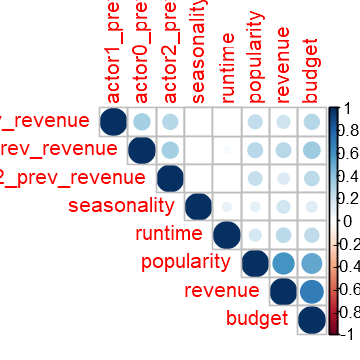

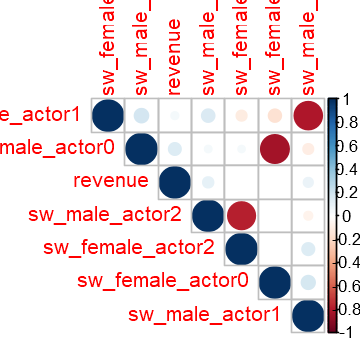

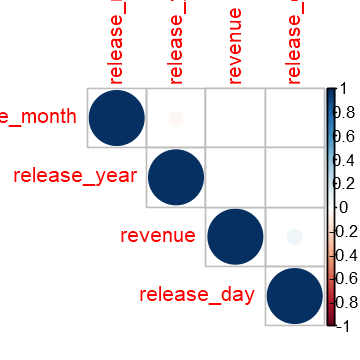

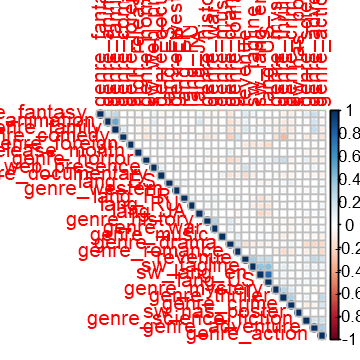

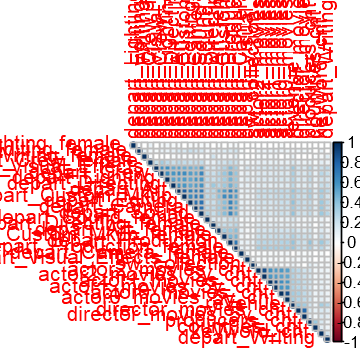

In [72]:
options(repr.plot.width = 3, repr.plot.height = 3)
corrplot(res1$r, type="upper", order="hclust", 
         p.mat = res1$P, sig.level = 0.01, insig = "blank")
corrplot(res3$r, type="upper", order="hclust", 
         p.mat = res3$P, sig.level = 0.01, insig = "blank")
corrplot(res5$r, type="upper", order="hclust", 
         p.mat = res5$P, sig.level = 0.01, insig = "blank")
corrplot(res2$r, type="upper", order="hclust", 
         p.mat = res2$P, sig.level = 0.01, insig = "blank")
corrplot(res4$r, type="upper", order="hclust", 
         p.mat = res4$P, sig.level = 0.01, insig = "blank")

# 4. Describing "revenue"
The "Revenue" is not normally distributed 
In the histogram we can see that most of the data are located in the "small" scale and little in the "big".. 
In addition, the Mean(=6.688e+07) and the Median(=1.693e+07) are very different.

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
1.000e+00 2.405e+06 1.693e+07 6.688e+07 6.906e+07 1.520e+09      4382 

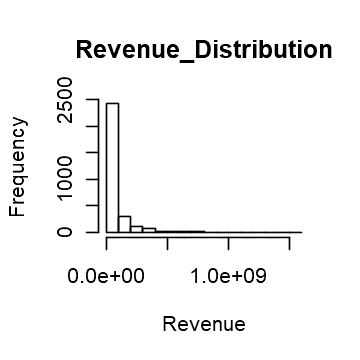

In [13]:
options(repr.plot.width = 3, repr.plot.height = 3)
summary(movies_ff_v$revenue)
hist(movies_ff_v$revenue
     ,main="Revenue_Distribution"
     ,xlab="Revenue"
     ,ylab="Frequency")

# Tring to find any var that change Revenue's distribition:
From the pairs function we can see that the budget gives some kind of linear distribiution aginst the revenue. 

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Removed 4382 rows containing non-finite values (stat_

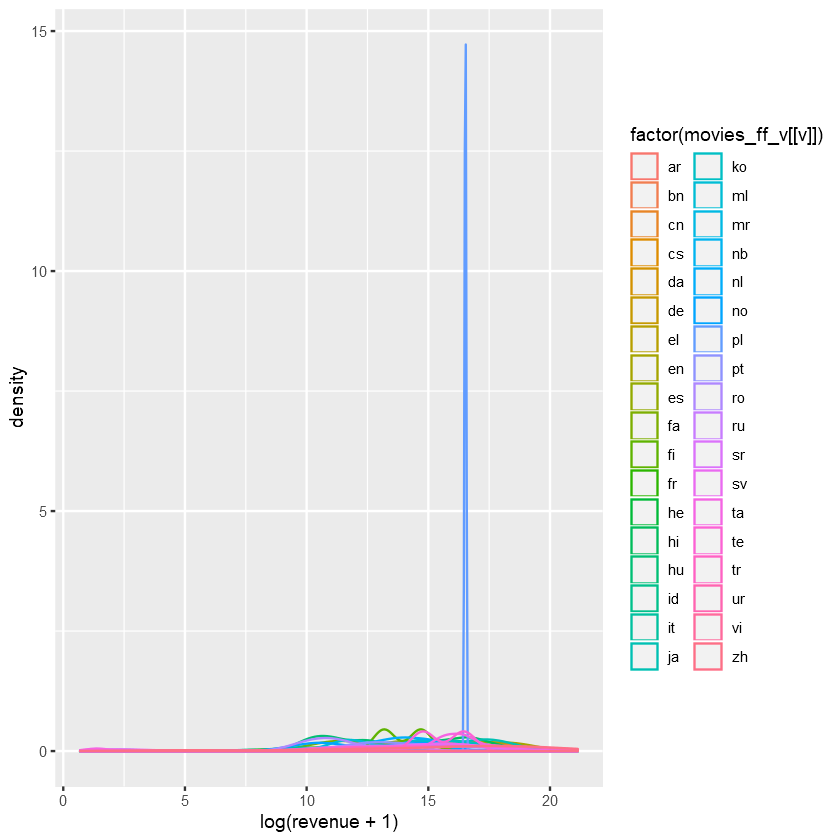

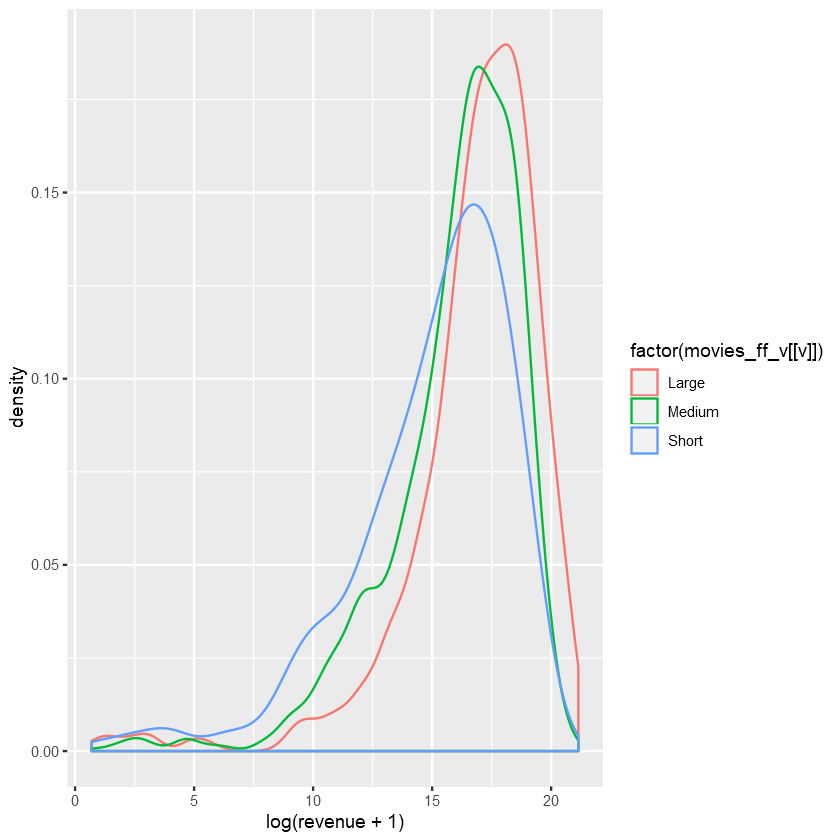

In [13]:
nm <-c("original_language","runtime_cat")
for (v in nm){
g1 <- ggplot(data=movies_ff_v) +
   geom_density(aes(log(revenue+1), col=factor(movies_ff_v[[v]]),group=factor(movies_ff_v[[v]])))
    plot(g1)
}


# 5. Outliers
The pairs function can give us a clue about the outliers, in addition, in the "mechkar" we can see all about the outliers

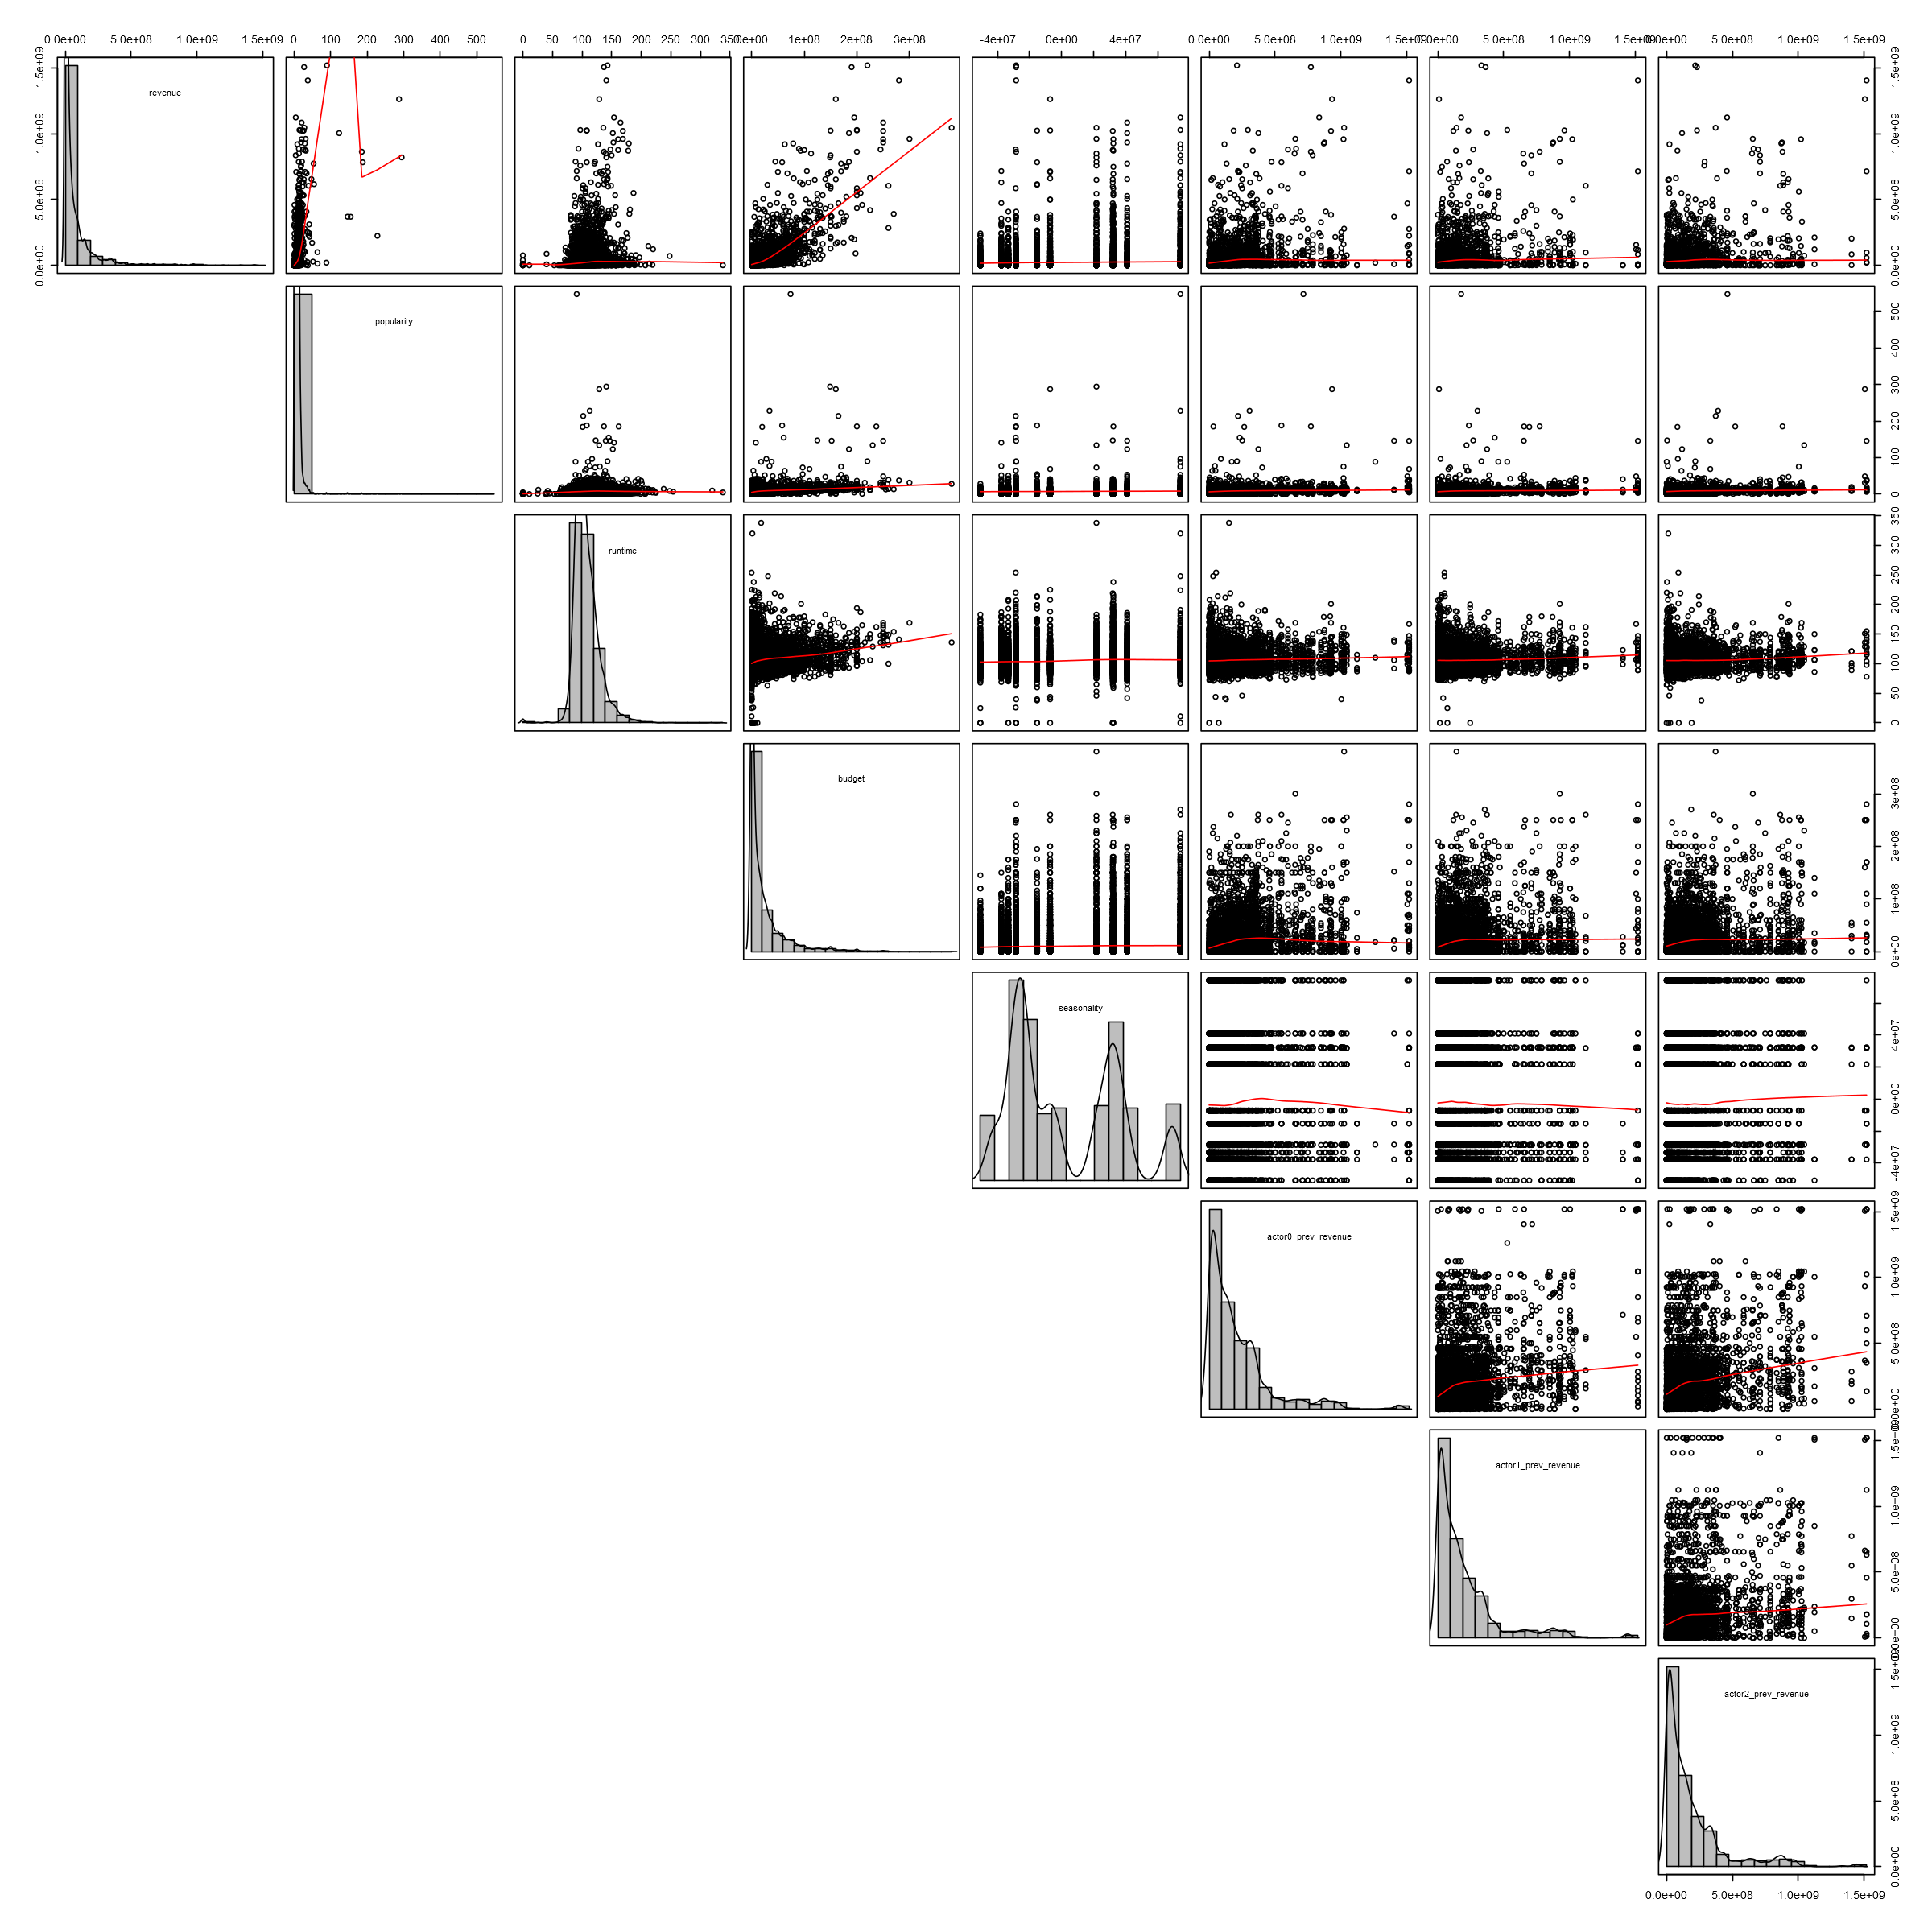

In [102]:
options(repr.plot.width = 20, repr.plot.height = 20)
pairs((movies_ff_v[,zm1]), 
      upper.panel = panel.smooth,
      diag.panel = panel.hist, 
      lower.panel = NULL,
      cex=0.8)

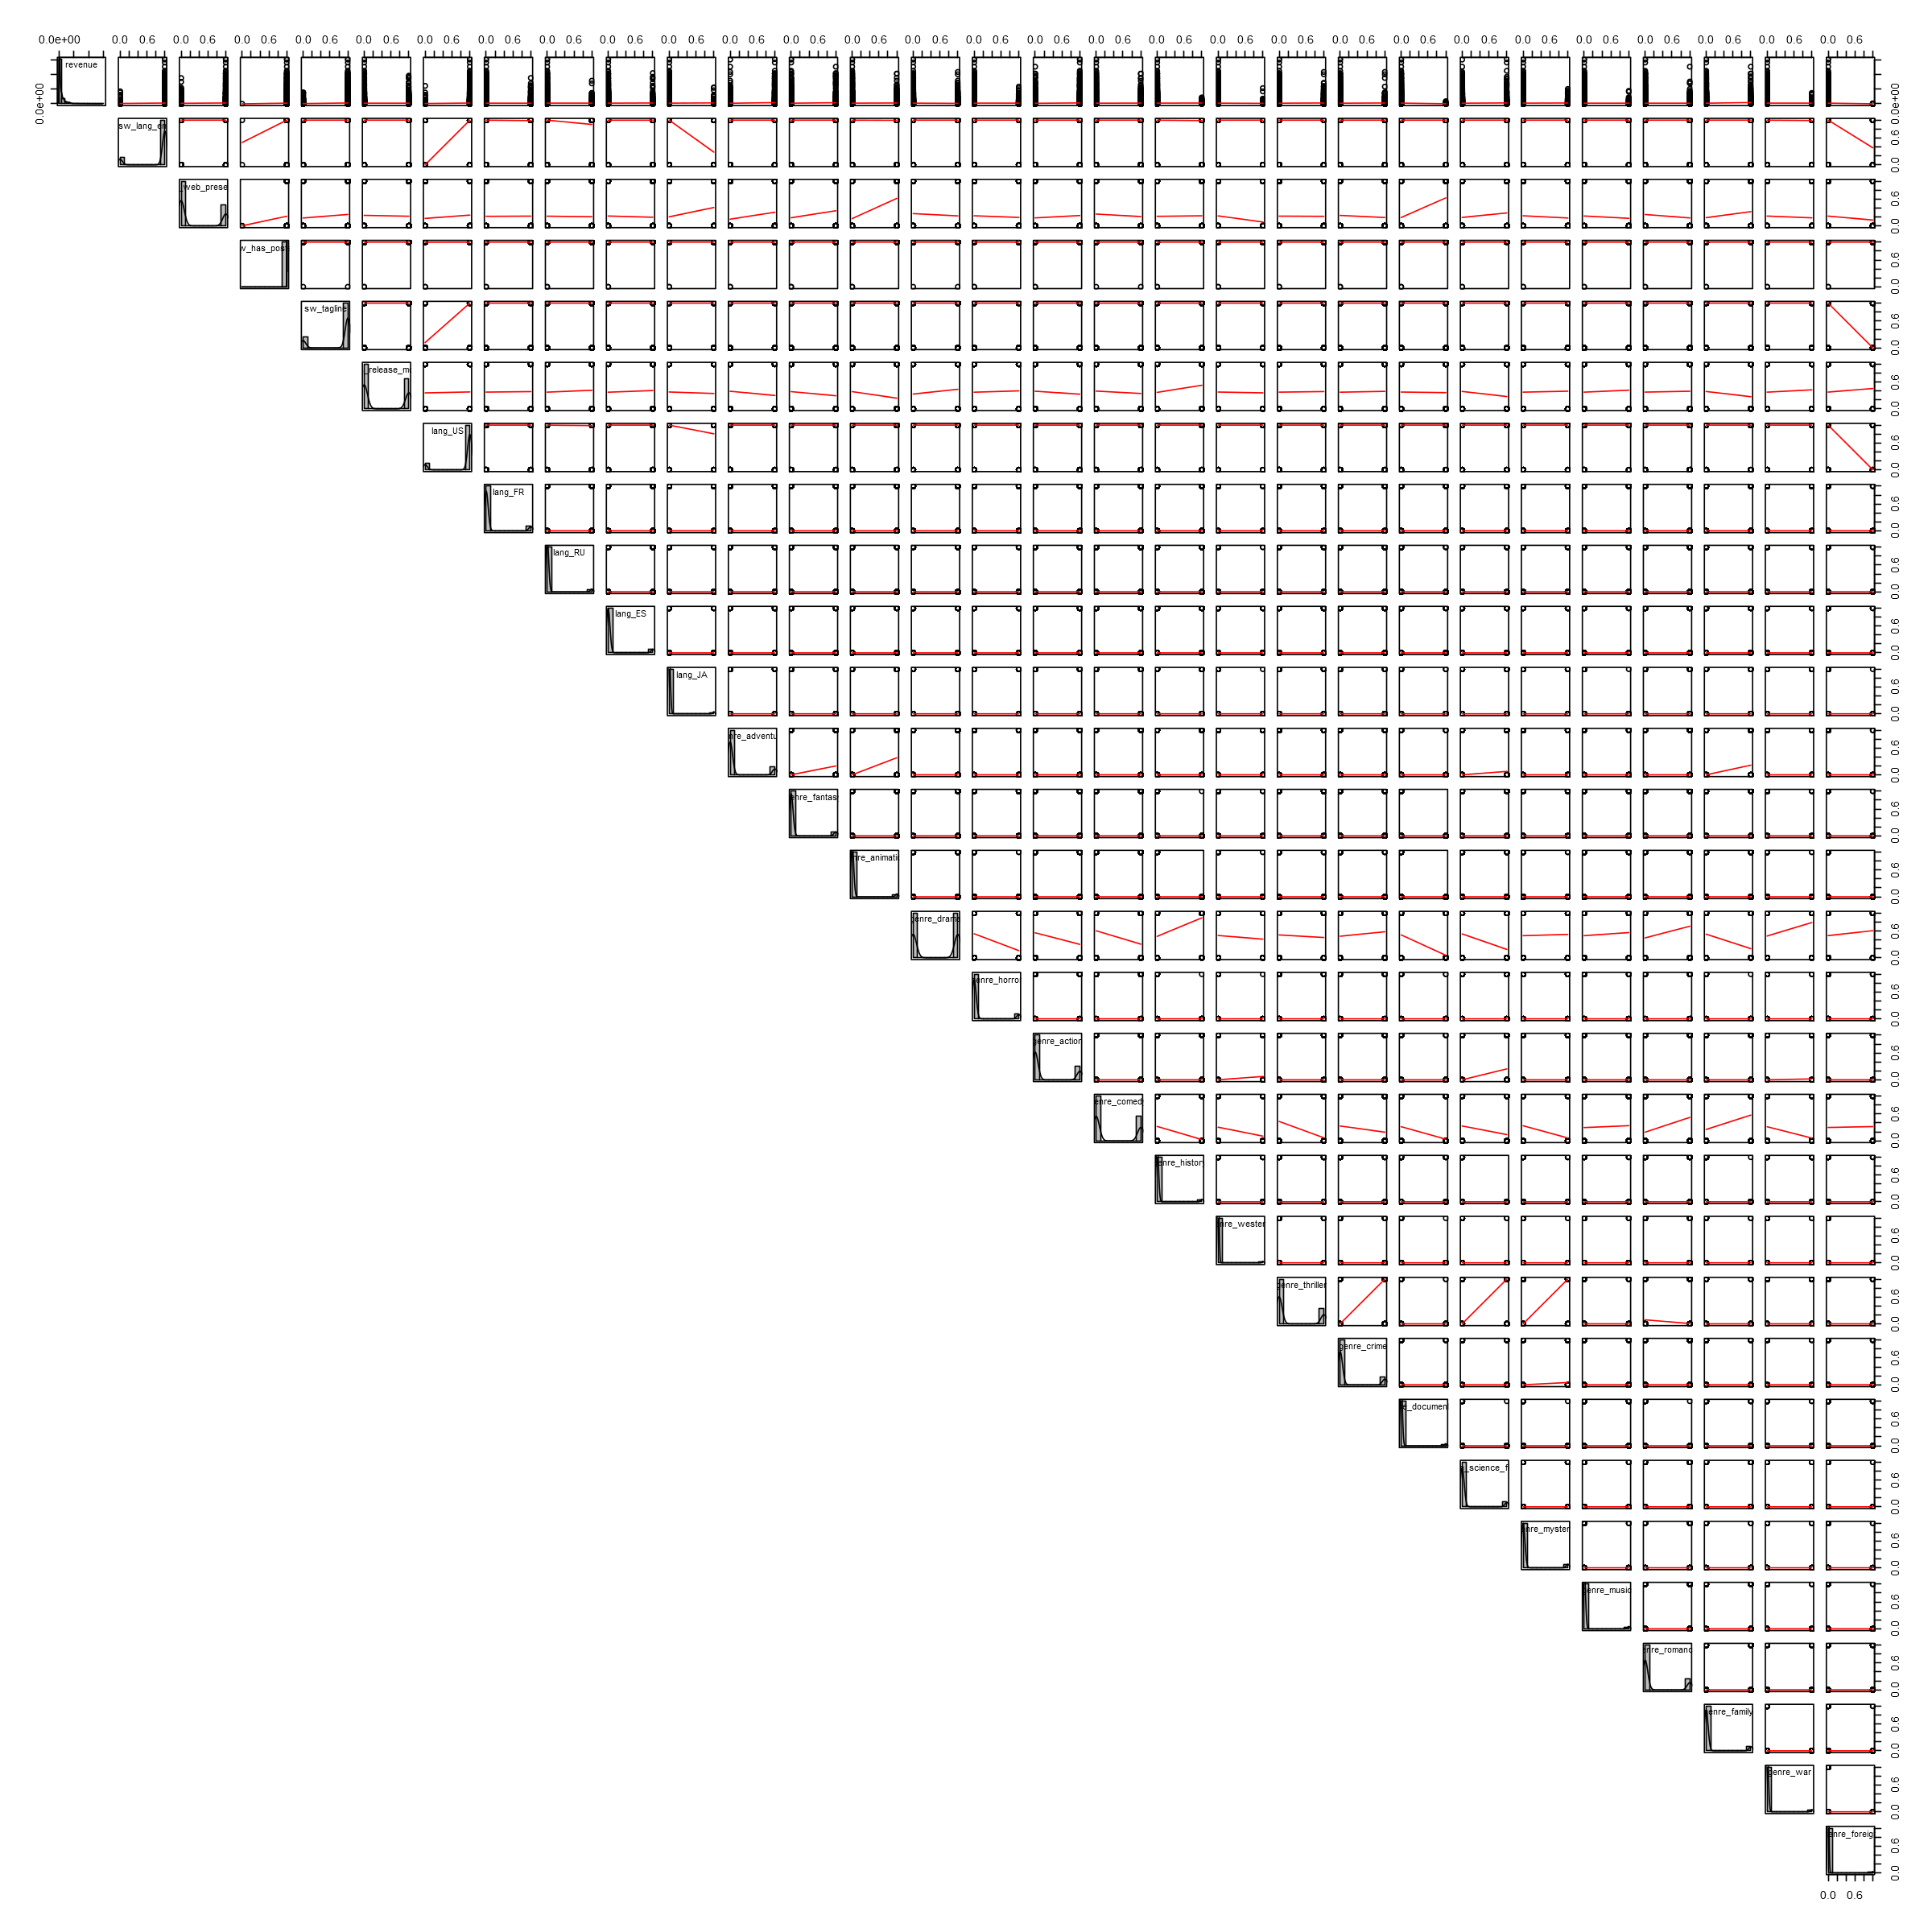

In [78]:
options(repr.plot.width = 20, repr.plot.height = 20)
pairs((movies_ff_v[,zm2]), 
      upper.panel = panel.smooth,
      diag.panel = panel.hist, 
      lower.panel = NULL,
      cex=0.8)

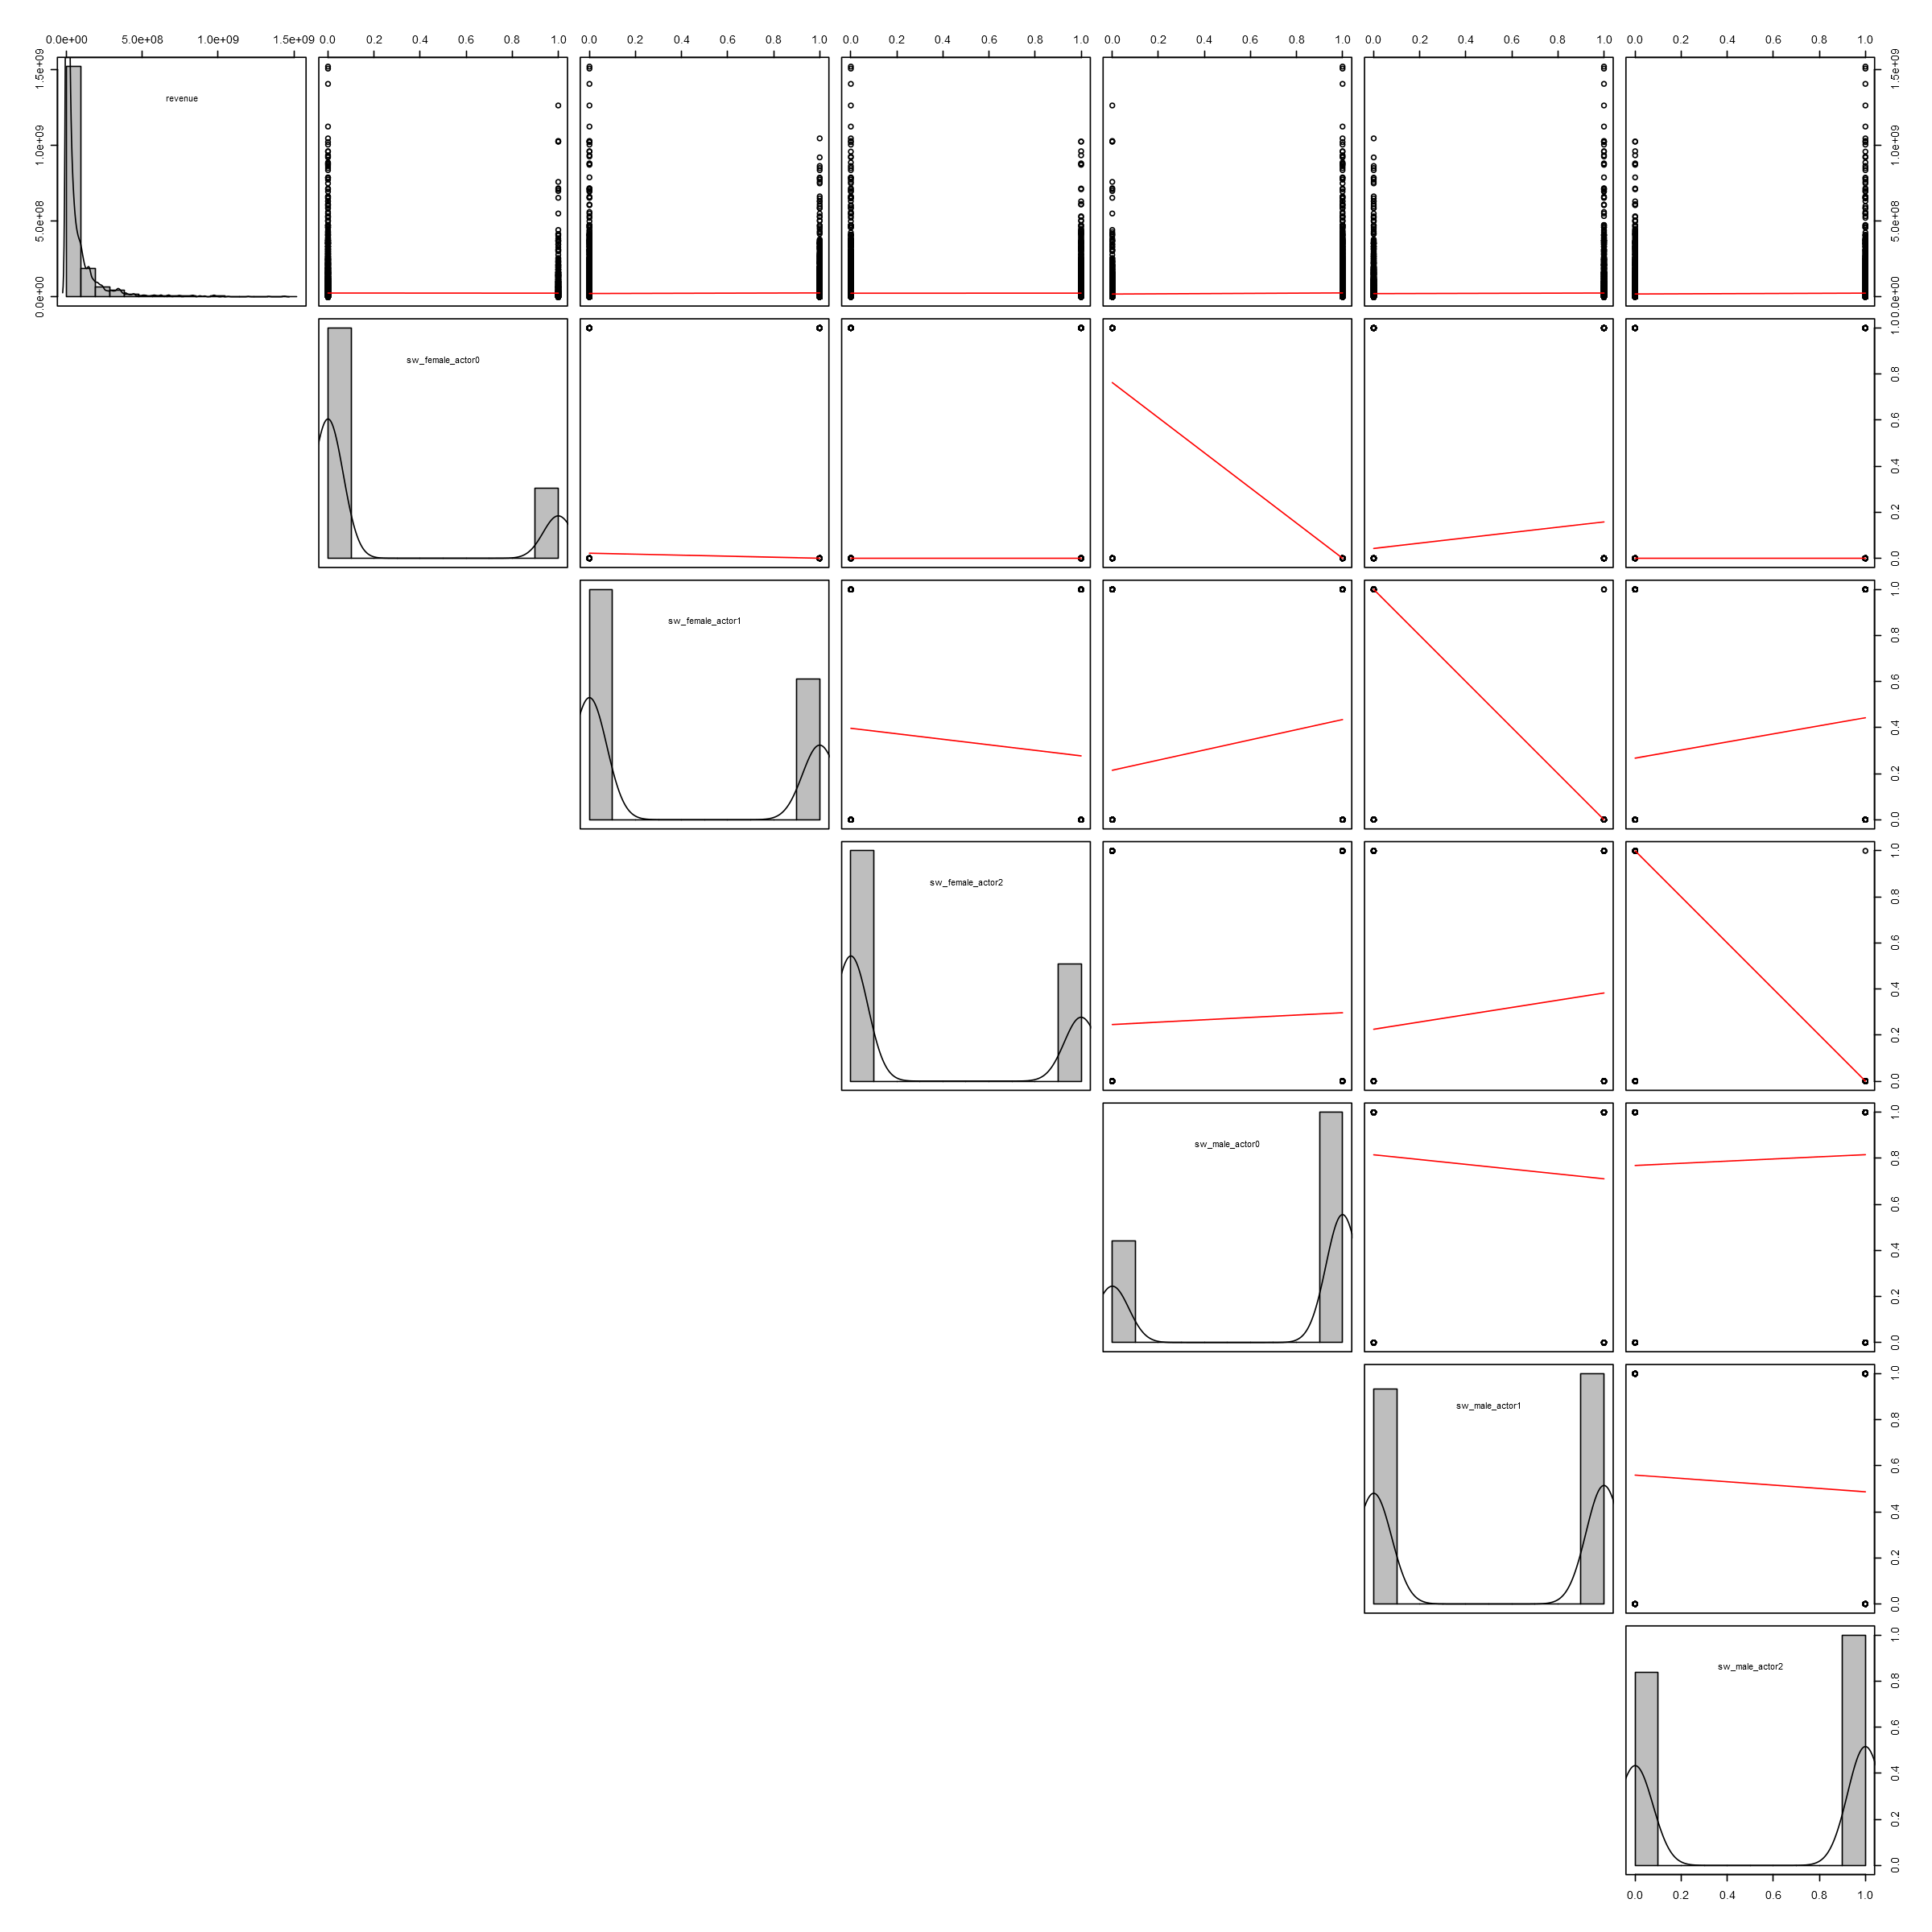

In [103]:
options(repr.plot.width = 20, repr.plot.height = 20)
pairs((movies_ff_v[,zm3]), 
      upper.panel = panel.smooth,
      diag.panel = panel.hist, 
      lower.panel = NULL,
      cex=0.8)

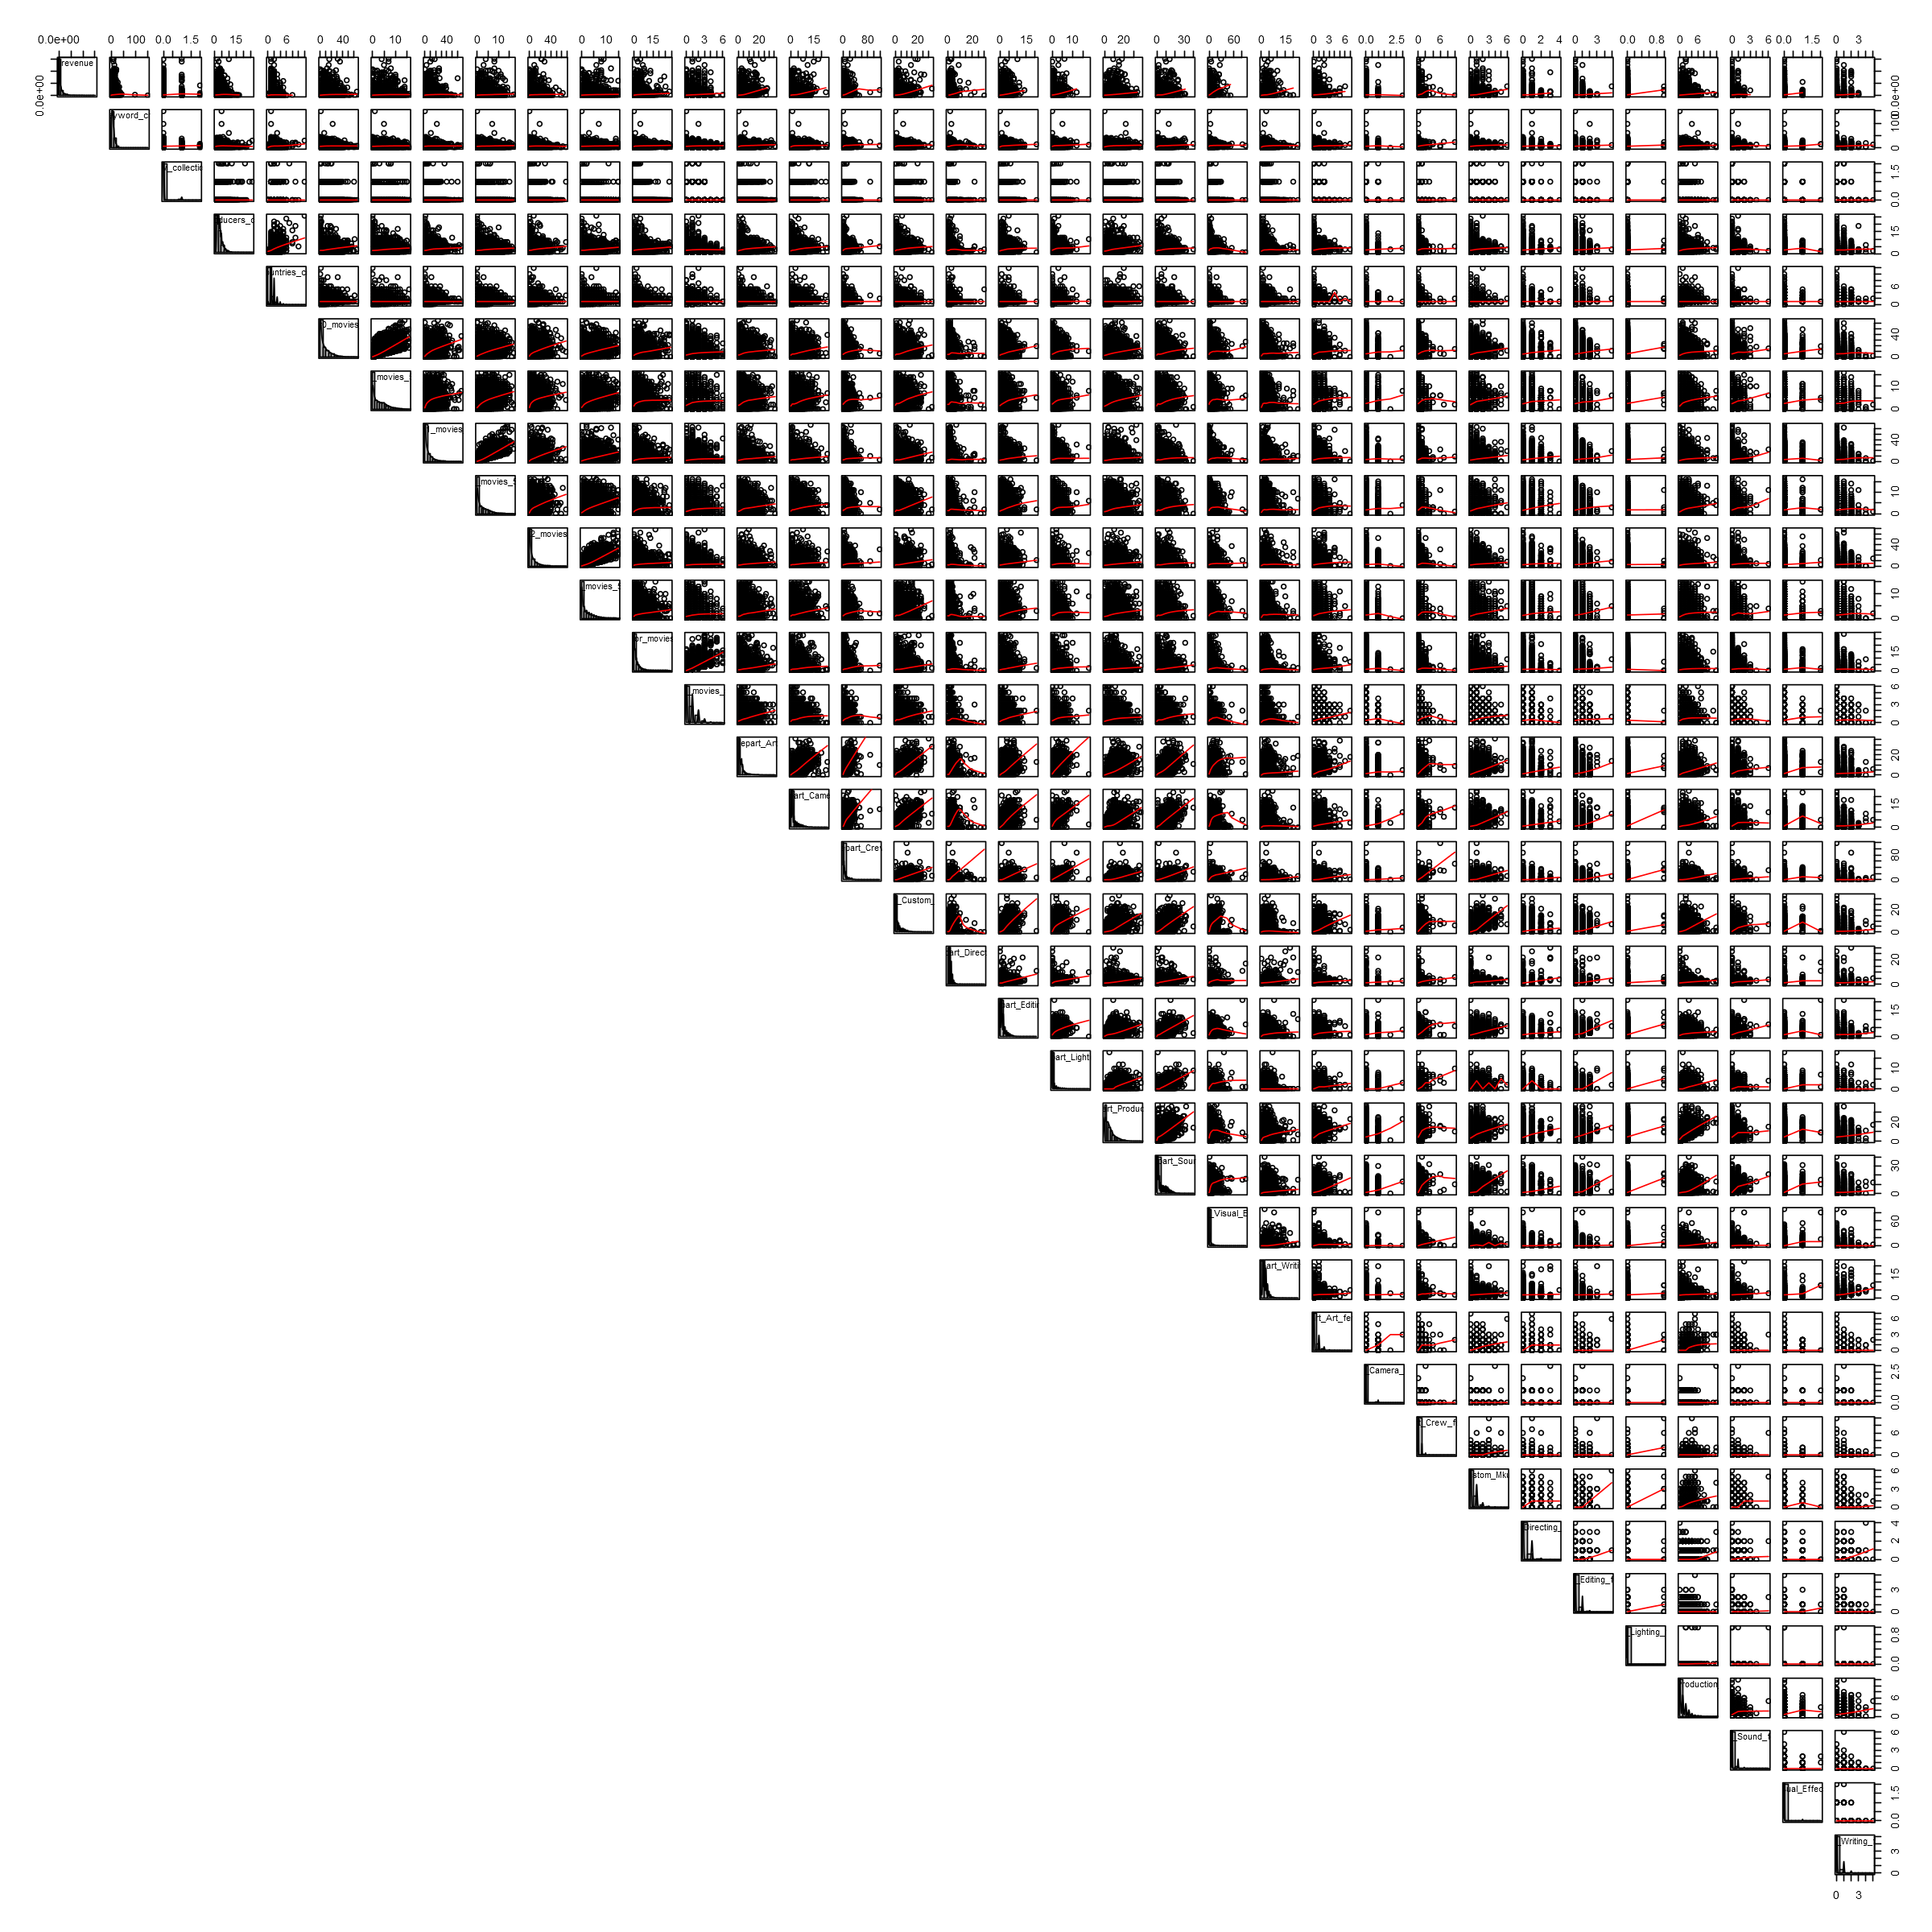

In [72]:
options(repr.plot.width = 20, repr.plot.height = 20)
pairs((movies_ff_v[,zm4]), 
      upper.panel = panel.smooth,
      diag.panel = panel.hist, 
      lower.panel = NULL,
      cex=0.8)

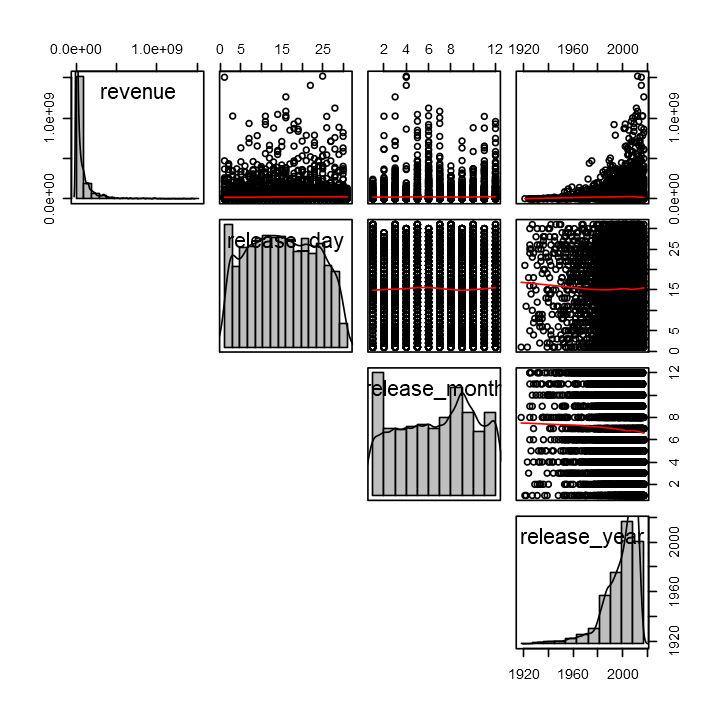

In [71]:
options(repr.plot.width = 6, repr.plot.height = 6)
pairs((movies_ff_v[,zm5]), 
      upper.panel = panel.smooth,
      diag.panel = panel.hist, 
      lower.panel = NULL,
      cex=0.8)

# 6. Finding the NULLs
The Vars with Nulls are presented in the summary function

# 7. Missing matrix

In [37]:
missingMatrix <- function(data) {
    vn <- names(data)
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[v] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}

minmax <- function(x) {  #minmax if we have data of 1000 number we chnage it into 1 and 0 but keep the distribiution it change the borders and the alogritm works better
    return(((x-min(x,na.rm=T))/(max(x,na.rm=T)-min(x,na.rm=T))))
}

getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [38]:
head(missingMatrix(movies_ff_v))

,movie_id,budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


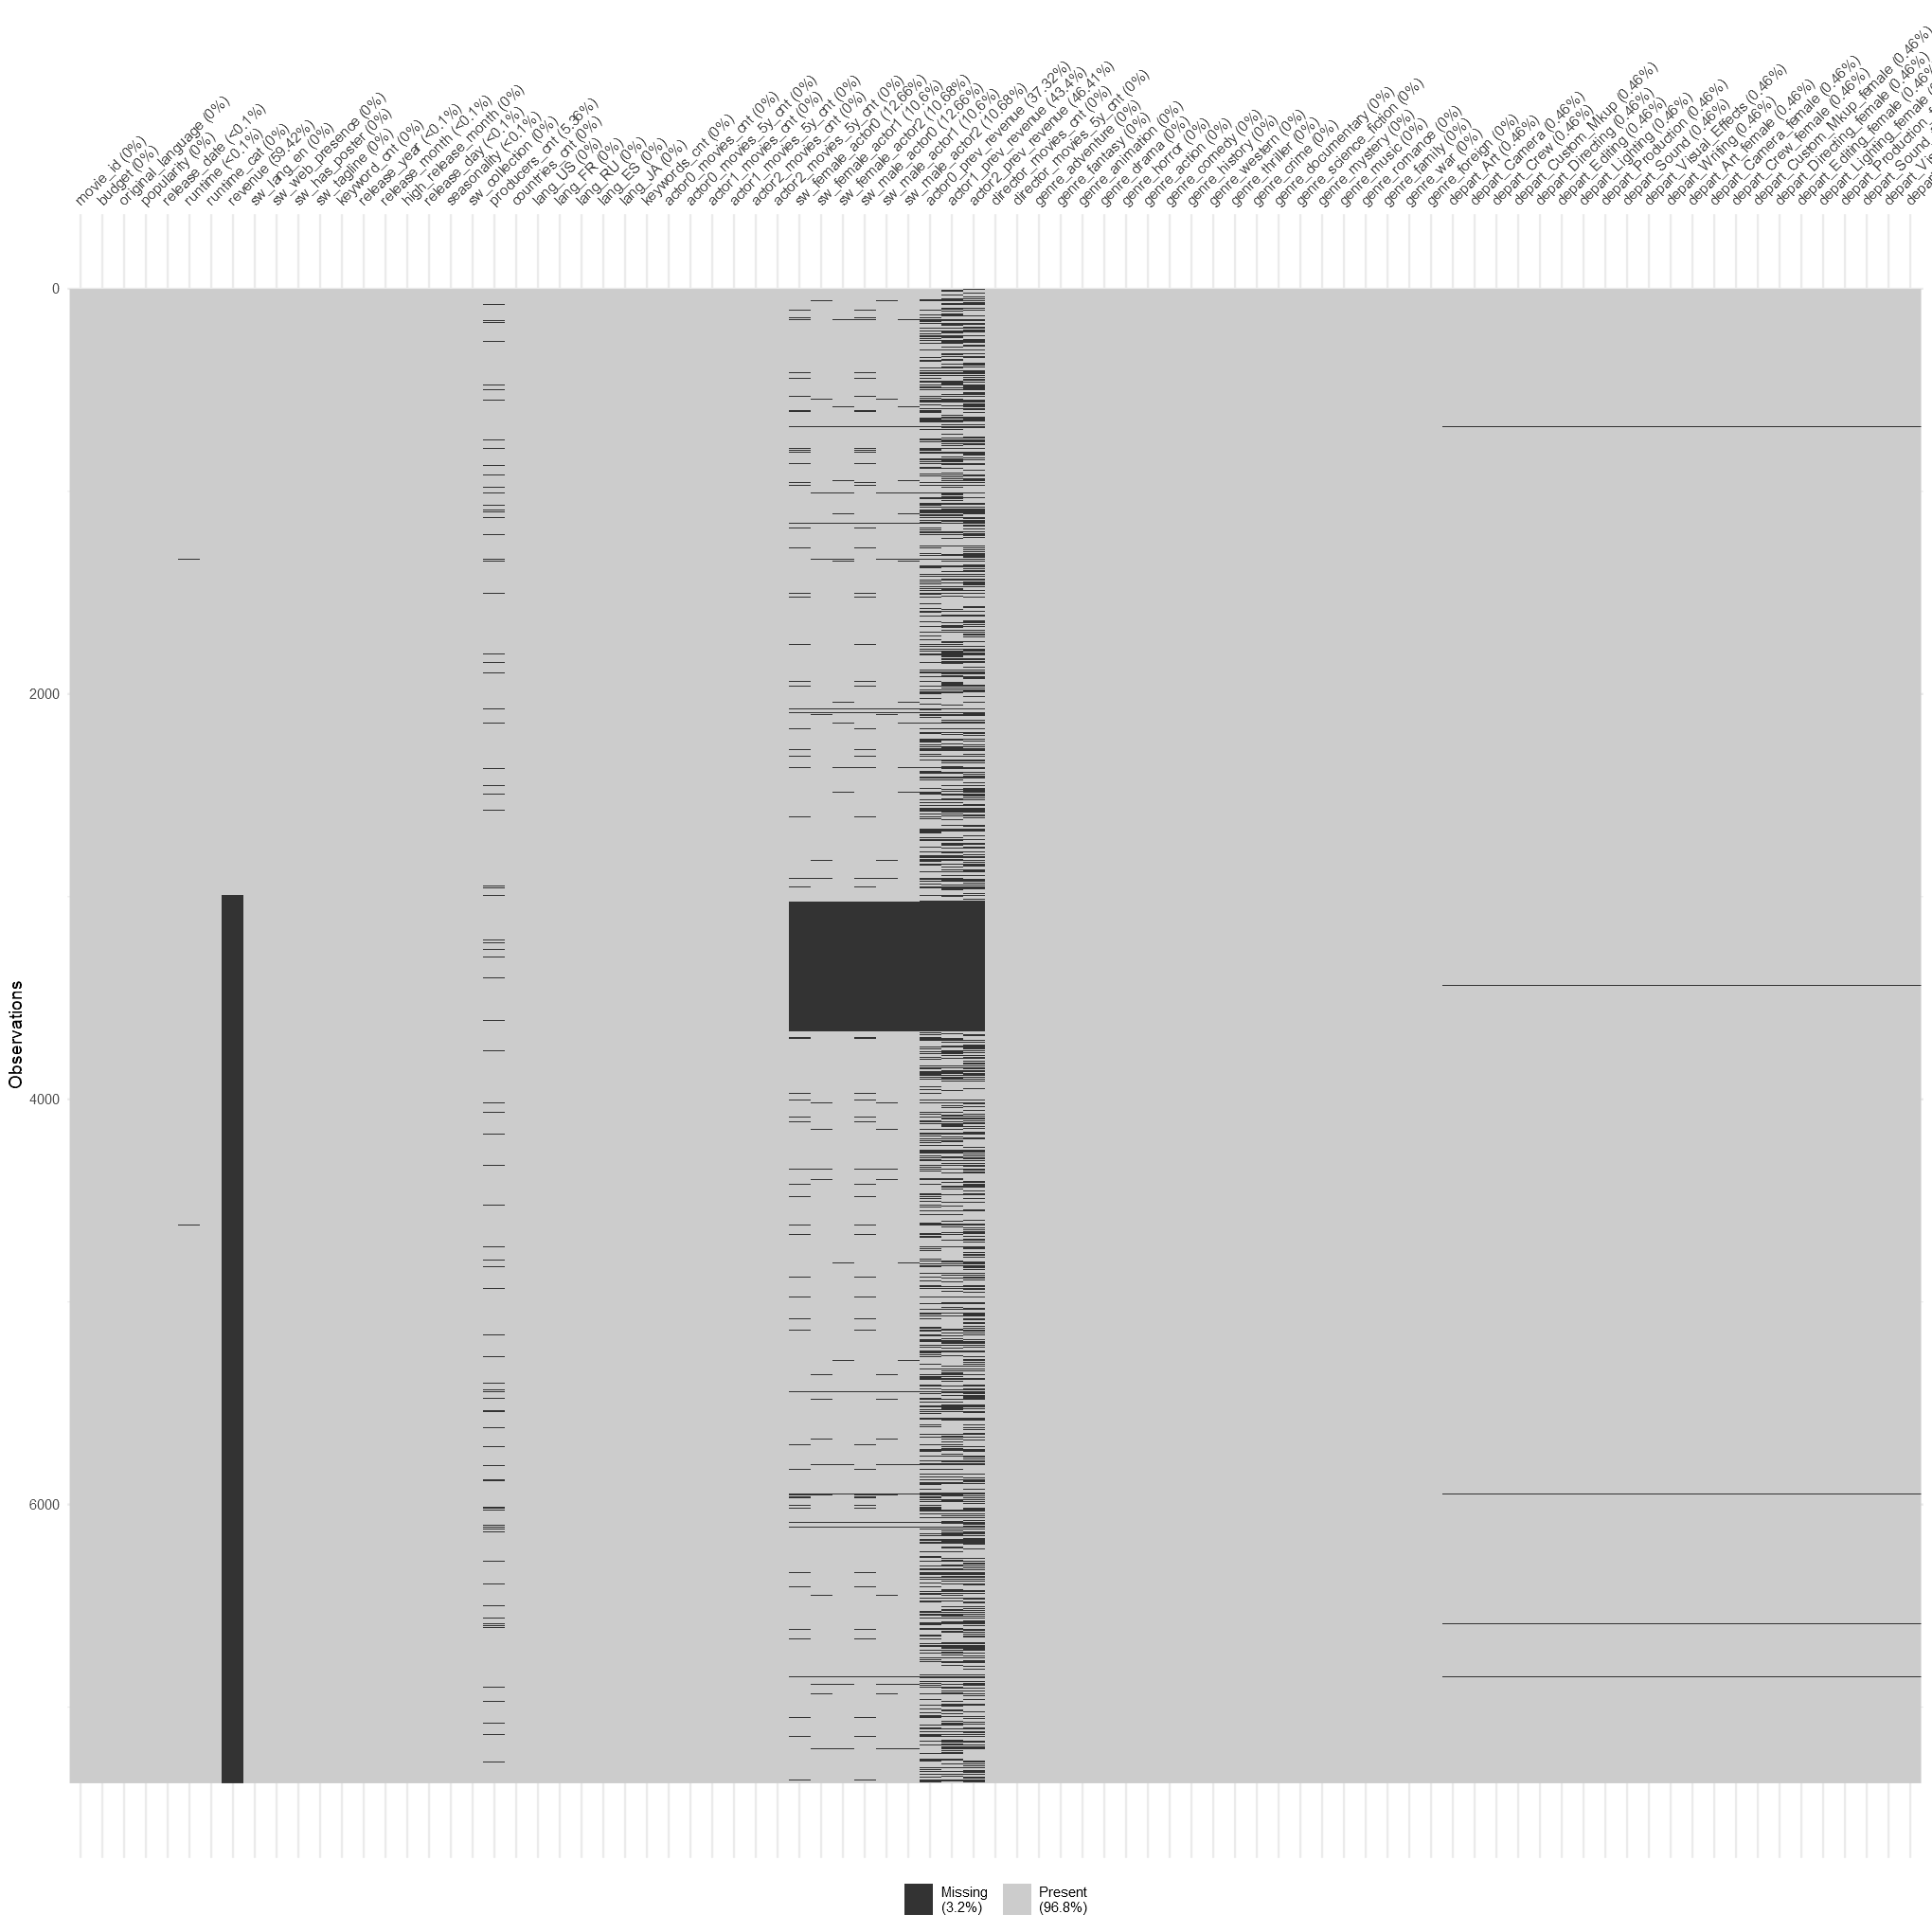

In [42]:
options(repr.plot.width = 17, repr.plot.height = 17) # the black boxes are missing values
vis_miss(movies_ff_v) # the vis_miss crate the heatmap

# Data cleaning